In [1]:
#Hierbij de uitwerking van mijn eindopdracht voor Data Science 2019/2020

#Ik maak gebruik van een paar bijzondere libaries. Het is daarom aan te raden om eerst de installs van de volgende 
#libaries uit te voeren!

In [12]:
#Het begint altijd met het importen van de benodigde libaries en de dataset.
import re
import os
import io
import spacy
import nltk
import requests
import warnings
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn import svm 
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("Zakelijk_SpeechInput_Orgineel.csv",encoding='ISO-8859-1')
df = df.drop(df.columns[[0, 1, 2, 3, 4, 5, 6]], axis=1).fillna('-')
df.shape
df.head()

ImportError: cannot import name 'SVM' from 'sklearn.svm' (C:\Users\pasca\Anaconda3\lib\site-packages\sklearn\svm\__init__.py)

In [4]:
# All the functions I need for this exam
# first you see all the functions that I need to clean up the text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def normalize_corpus(corpus, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
    return normalized_corpus

#the next function is to determinate which classifier is the best
def classifier(clfs):
    for classifier in clfs:
        pipeline.set_params(clf=classifier)
        scores = cross_validate(pipeline, X_train, y_train)
        print('---------------------------------')
        print(str(classifier))
        print('-----------------------------------')
        for key, values in scores.items():
            print(key, ' mean ', values.mean())
            print(key, ' std ', values.std())
    return key, values

# the functions below are used for the Confusion Matrix
def plot_matrix(data):
    plt.figure()
    plt.matshow(data)
    plt.show()

def conf_els(conf, labels):
    tot = conf.sum().sum()
    cols = conf.sum(axis=0)
    rows = conf.sum(axis=1)

    tp = conf.diagonal()
    fp = cols - tp
    fn = rows - tp
    tn = tot - tp - fp - fn

    res = list(zip(labels, tp, fp, fn, tn))
    return res


def conf_data(metrics):
    tp = sum([foo[1] for foo in metrics])
    fp = sum([foo[2] for foo in metrics])
    fn = sum([foo[3] for foo in metrics])
    tn = sum([foo[4] for foo in metrics])

    rv = {}
    rv['tpr'] = tp / (tp + fn)
    rv['ppv'] = tp / (tp + fp)
    rv['tnr'] = tn / (tn + fp)
    rv['fpr'] = fp / (fp + tn)

    return rv

In [5]:
# Here I load the dutch libary and will parse al the text in the file through the Normalize function to get a clean text.
nlp = spacy.load('nl_core_news_sm', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('dutch')
df['clean_text'] = normalize_corpus(df['User Input'])
df.head(100)

,User Input,Label,clean_text
0,-6,DBZ1,
1,-,DBZ2,
2,-,DBZ2,
3,-,DBZ2,
4,1,DBZ1,
...,...,...,...
95,activeren scanner,Technisch,activeren scanner
96,-,DBZ2,
97,activeren scanner,Technisch,activeren scanner
98,activeren scanner,Technisch,activeren scanner


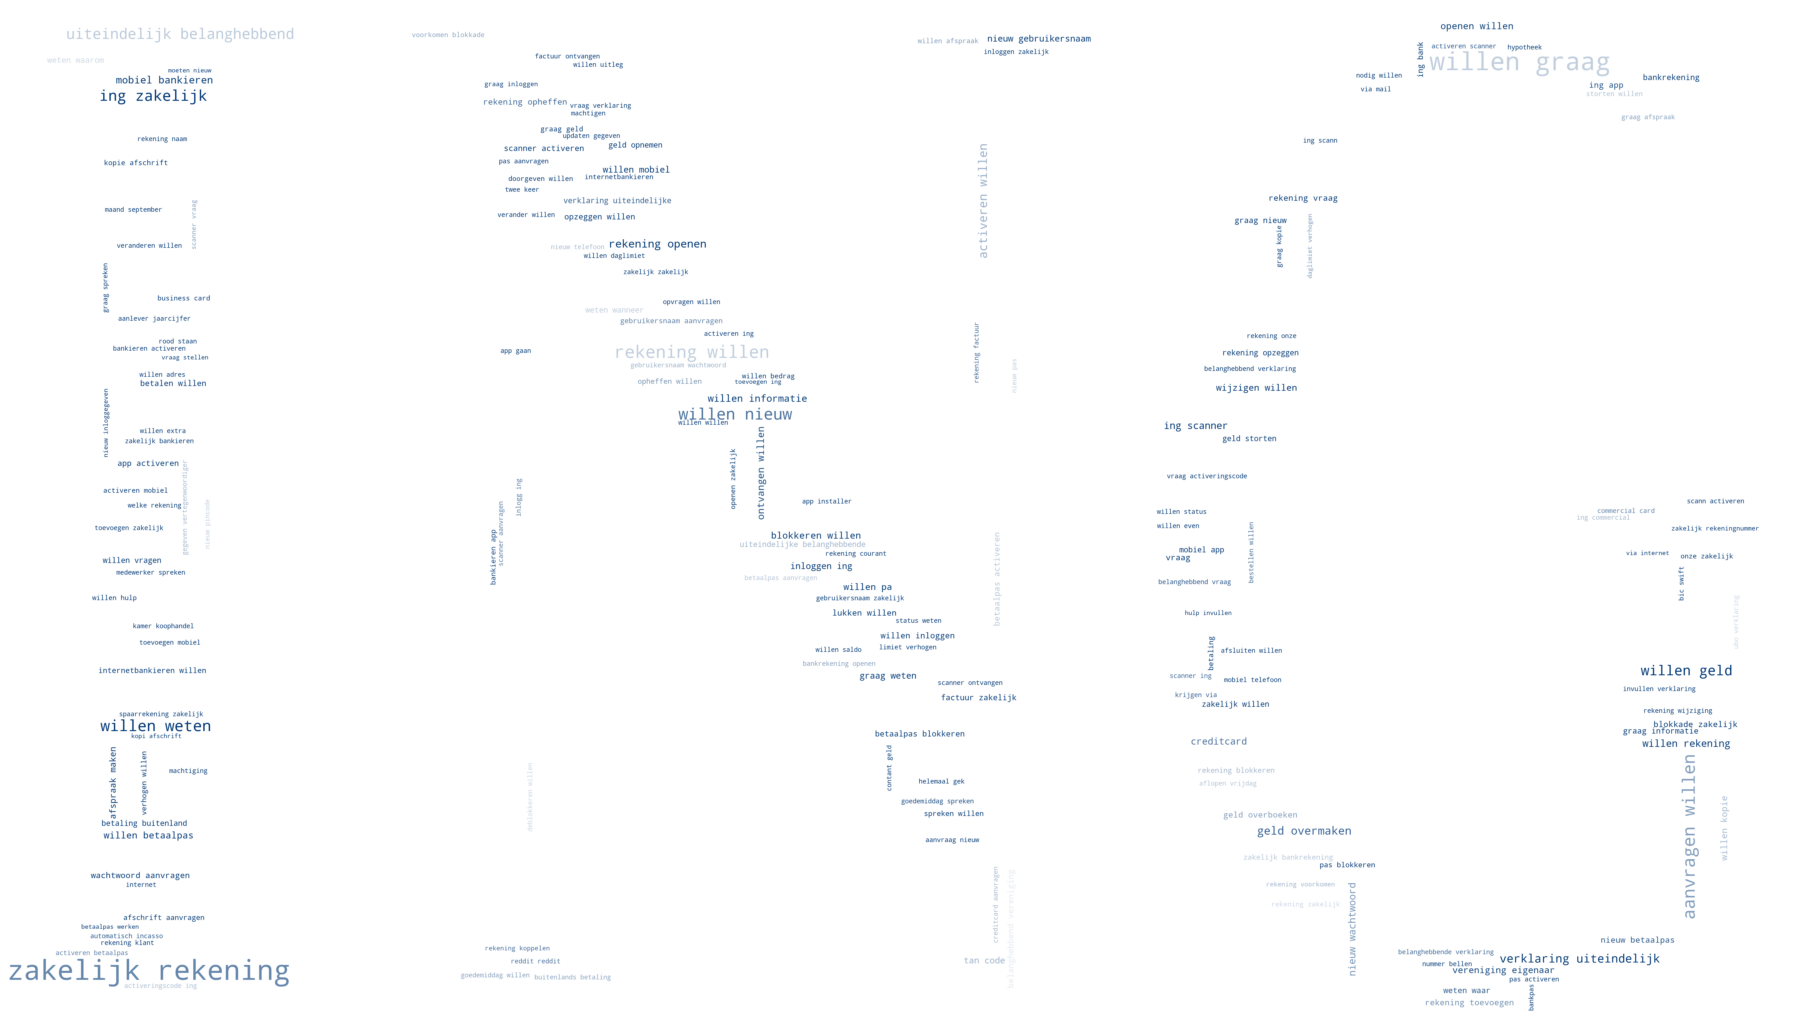

In [5]:
# To see which are to most common words I created a Wourdcloud in a shape of a skull representing the data science we are 
#working with

comment_words = ' ' 
# iterate through the csv file 
for val in df['clean_text']:     
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
        for words in tokens: 
            comment_words = comment_words + words + ' '
            
mask = np.array(Image.open( "ING6.png"))
image_colors = ImageColorGenerator(mask)
wordcloud = WordCloud(width=1600,
                      height=800,
                      background_color="white", 
                      mask=mask,
                      color_func = image_colors).generate(comment_words)

# Display the generated image:
plt.figure( figsize=(25,15) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

In [13]:
# Now we need to split the data, to create a train and test set to see how well the classifier will proform
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df["Label"], test_size=0.2, random_state=0)

In [14]:
# But first I need to determine which classifier to use. Therefor I created this pipeline to help me out.
pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000)),
                     ('clf', SVC())])

In [15]:
# Here I will iterate through all the moste common classifiers. I will see that the Super Vector Matri will proform the best.
# Only it takes the longest to fit

clfs = []
clfs.append(LogisticRegression())
clfs.append(SVC(kernel='linear'))
clfs.append(KNeighborsClassifier(n_neighbors=5))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())

best_classifier = classifier(clfs)
print(best_classifier)



---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
fit_time  mean  0.09998281796773274
fit_time  std  0.01299290604933819
score_time  mean  0.028550068537394207
score_time  std  0.0022139908389449715
test_score  mean  0.8311152491895296
test_score  std  0.007779615149541681
---------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
-----------------------------------
fit_time  mean  0.900979200998942
fit_time  std  0.031042412429569

In [9]:
#The code below will find the best parameters for SVM. The downside of this piece of code is that it takes ages on my computer
#luckly this codes as to run only once. The end goal is to find out what the accurcy score will be after finding the pest 
#params and what the best params are.
pipeline.set_params(clf=SVC())
pipeline.steps
cv_grid = GridSearchCV(pipeline, param_grid={
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': np.linspace(0.1, 1.2, 12),
    'clf__gamma': np.linspace(0.1, 1.2, 12)
})

cv_grid.fit(X_train, y_train)
cv_grid.best_params_
cv_grid.best_estimator_
cv_grid.best_score_
y_predict = cv_grid.predict(X_test)
accuracy = accuracy_score(y_test, y_predict)

In [10]:
#Here is the printout of the the accurcyscore en the best params for the SVM classifier
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy * 100))
print('-------------------')
print(cv_grid.best_params_)

Accuracy of the best classifier after CV is 87.924%
-------------------
{'clf__C': 1.2, 'clf__gamma': 1.2, 'clf__kernel': 'rbf'}


In [11]:
#Here I created an updated pipeline withe the best params found with GridseachCV. 
#After that I fitted the model on the trainingsset

model = Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000)), 
          ('clf', SVC(C=1.2, kernel= 'rbf', gamma=1.2))])

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1.2, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1.2,


In [12]:
#Here you'll see the metrics off the classifier. The trainingset has been used by the model and with the metrics we can see
#how well it preformed by using the testset.
print('SVM Accuracy Score ->')
print(accuracy_score(model.predict(X_test), y_test) * 100)
print('----------------------------------------')
print('Classification Report ->')
print(classification_report(y_test, model.predict(X_test)))
print('-------------------')
print('Confusion Matrix ->')
print(confusion_matrix(model.predict(X_test), y_test))

SVM Accuracy Score ->
87.92372881355932
----------------------------------------
Classification Report ->
              precision    recall  f1-score   support

     Complex       0.97      0.85      0.90        98
        DBZ1       0.69      0.86      0.77       163
        DBZ2       0.98      0.95      0.96       295
      Simpel       0.83      0.81      0.82       208
   Technisch       0.95      0.88      0.91       180

    accuracy                           0.88       944
   macro avg       0.88      0.87      0.87       944
weighted avg       0.89      0.88      0.88       944

-------------------
Confusion Matrix ->
[[ 83   0   0   3   0]
 [  8 140   8  32  15]
 [  0   4 280   1   1]
 [  5  17   6 169   6]
 [  2   2   1   3 158]]


<Figure size 432x288 with 0 Axes>

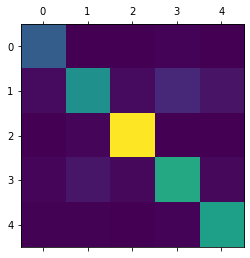

[('Complex', 83, 15, 3, 843), ('DBZ1', 140, 23, 63, 718), ('DBZ2', 280, 15, 6, 643), ('Simpel', 169, 39, 34, 702), ('Technisch', 158, 22, 8, 756)]

Bepalen van de scores:

{'tpr': 0.8792372881355932, 'ppv': 0.8792372881355932, 'tnr': 0.9698093220338984, 'fpr': 0.030190677966101694}


In [13]:
#A detailed version of the Confusion Matrix.

data = np.array(confusion_matrix(model.predict(X_test), y_test))
plot_matrix(data)

labels = ['Complex','DBZ1','DBZ2','Simpel','Technisch']

TP = np.diagonal(data)
FP = np.sum(data, axis=0) - TP
FN = np.sum(data, axis=1) - TP
TN = data.sum() - TP - FP - FN

conf_els(data, labels)

metrics = conf_els(data, labels)
print(metrics)
print()
print("Bepalen van de scores:")
print()
scores = conf_data(metrics)
print(scores)